In [1]:
!pip install opencv-contrib-python-headless

In [2]:
import pandas as pd
import numpy as np
import warnings
from datetime import datetime
import os
import boto3
import random
import matplotlib.pyplot as plt
from PIL import Image

import mlflow
import cv2
import glob

import tensorflow as tf
plt.style.use("fivethirtyeight")
pd.plotting.register_matplotlib_converters()

warnings.filterwarnings('ignore')

2024-01-14 17:20:19.689705: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 17:20:19.692625: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 17:20:19.748279: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 17:20:19.749910: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-14 17:20:20.865587: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [3]:
auth_token = 'eyJhbGciOiJSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJPRE9SdWotcVYtcnNBbm9HM0loRmFJWlc3TndiQjJNWmE4UFBfMnZtcHpjIn0.eyJleHAiOjE3MDU1NzUxMzIsImlhdCI6MTcwNDk3MDMzMiwiYXV0aF90aW1lIjoxNzA0OTcwMzMyLCJqdGkiOiIyYzkwNGVhOC1hNjliLTQ1N2ItYTE1MC1iNDJiODY4NjFiMmMiLCJpc3MiOiJodHRwczovL2tleWNsb2FrLnVhLmV6bS5sb2NhbC9yZWFsbXMvVUEiLCJhdWQiOiJ1YSIsInN1YiI6ImM0Nzc5NDkwLWQ5NDUtNGRhYi1hODI5LTdhYTViZDU5N2RkNCIsInR5cCI6IklEIiwiYXpwIjoidWEiLCJub25jZSI6IlNZMHBqeFFaSUtESW5VQ1VpWkhNNGpEVVNoVVVKZ0JscmJ2akplMGNzVjAiLCJzZXNzaW9uX3N0YXRlIjoiMGQwZDJiMWUtNDVjMC00M2JhLTk3ZmItYTQ3MjhkZGEwZTJmIiwiYXRfaGFzaCI6IkwtY3dOZEV5WEc5VWhXRHBDSlFXaXciLCJhY3IiOiIxIiwic2lkIjoiMGQwZDJiMWUtNDVjMC00M2JhLTk3ZmItYTQ3MjhkZGEwZTJmIiwidWlkIjoiNjAwMiIsImVtYWlsX3ZlcmlmaWVkIjpmYWxzZSwiZ2lkIjoiNTAwNSIsIm5hbWUiOiJkZW1vIEFuUFMiLCJncm91cHMiOlsidWEtZW5hYmxlZCIsIm9mZmxpbmVfYWNjZXNzIiwiYWRtaW4iLCJ1bWFfYXV0aG9yaXphdGlvbiIsImRlZmF1bHQtcm9sZXMtdWEiXSwicHJlZmVycmVkX3VzZXJuYW1lIjoiZGVtbyIsImdpdmVuX25hbWUiOiJkZW1vIiwicG9zaXhfdXNlcm5hbWUiOiJkZW1vIiwiZmFtaWx5X25hbWUiOiJBblBTIiwiZW1haWwiOiJkZW1vQGV6dWEuY29tIn0.Ekt_F1CnYtf78rs6_NgAlqXJyjMoZOqUf6nLwg929lB0dQ7xdpwK7I2UToaHoXS2z73U3ATWD3mGU0ZQ5dR4VChJCPjocN0gRQWWyw0AjHeKzbAhTCGVKgP26HqK1VHi10SBed_q5S_n8j47_QVRBXB6ANQ3UmbmnzMLR1mJH-zaH_jDF4rlfC8UB28sMVQm8lzKBRFCJrRCfkTpoStXZ7AwnXMzDcs4c4D7O3sRMxTC-iA2rT9sFioA4Z51-PwXjk-l0g6Qw8w846winmMhP84uyIgsd4g9jqn2ZYOH9Hkl7F-pS9GdqKaNodRVKWo0SknL4RpiMJxNckrxEbQOxg'

os.environ["AWS_ACCESS_KEY_ID"]      = auth_token 
os.environ["AWS_SECRET_ACCESS_KEY"]  = "s3"
os.environ["AWS_ENDPOINT_URL"]       = 'http://local-s3-service.ezdata-system.svc.cluster.local:30000'
os.environ["MLFLOW_S3_ENDPOINT_URL"] = 'http://local-s3-service.ezdata-system.svc.cluster.local:30000'
os.environ["MLFLOW_S3_IGNORE_TLS"]   = "true"
os.environ["MLFLOW_TRACKING_INSECURE_TLS"] = "true"

config = {
    "MINIO_HOST_URL": "http://minio-service.ezdata-system.svc.cluster.local:30000",
    "MINIO_ACCESS_KEY": auth_token,
    "MINIO_SECRET_KEY": "s3",
    "KSERVE_MODEL_NAME": "face-recognition",
    "NAMESPACE": open("/var/run/secrets/kubernetes.io/serviceaccount/namespace", "r").read(),
    "BUCKET": "demo",
    "FILE_PATH": "model",
    "SERVICE_ACCOUNT": "kserve-minio-sa",
    "PROTOCOL_VERSION": "v2"
} 

experiment_name =  "Face-Recognition"
model_name = "resnet18"
model_path = os.path.join("model/",model_name)

# 학습모델 로딩

In [4]:
mlflow.set_experiment(experiment_name)
#tf.saved_model.load(model_path)
model = tf.keras.models.load_model(model_path)
#1 Define Label
labels = ["황정민","이병헌","한석규","지진희","장동건","정우성","최민수","최민식","허준호","송강호"]
num_classes = len(labels)

image_row = 64
image_col = 64
image_color = 3
photo_shape = (image_row, image_col, image_color)

print(num_classes, photo_shape, labels)

2024-01-14 17:20:23.806741: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'add_5/PartitionedCall' has 1 outputs but the _output_shapes attribute specifies shapes for 3 outputs. Output shapes may be inaccurate.
2024-01-14 17:20:23.822033: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'add_7/PartitionedCall' has 1 outputs but the _output_shapes attribute specifies shapes for 3 outputs. Output shapes may be inaccurate.
2024-01-14 17:20:23.995019: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'add_1/PartitionedCall' has 1 outputs but the _output_shapes attribute specifies shapes for 3 outputs. Output shapes may be inaccurate.
2024-01-14 17:20:24.040612: W tensorflow/core/common_runtime/graph_constructor.cc:834] Node 'add_3/PartitionedCall' has 1 outputs but the _output_shapes attribute specifies shapes for 3 outputs. Output shapes may be inaccurate.
2024-01-14 17:20:24.323106: W tensorflow/core/common_runtime/graph_constructor.cc:834] N

10 (64, 64, 3) ['황정민', '이병헌', '한석규', '지진희', '장동건', '정우성', '최민수', '최민식', '허준호', '송강호']


In [5]:
def getPredict(model, photo_shape, image_path, labels):
    
    predict_images = []
    cascade_filename = "./haarcascade_frontalface_alt.xml"
    cascade = cv2.CascadeClassifier(cascade_filename)
        
    for photo in  glob.glob(image_path + '/*.jpg'):
        image = cv2.imread( photo, cv2.IMREAD_UNCHANGED )     
        face_xy = cascade.detectMultiScale(image, minSize=(150,150))
        if len(face_xy) == 1:
            for (x,y,w,h) in face_xy:
                face = image[y:y+h,x:x+w]
                face = cv2.resize(face, (photo_shape[0], photo_shape[1]))
                if face.shape == (photo_shape[0], photo_shape[1],photo_shape[2]):
                    predict_images.append(face)
                    
                    plt.figure(figsize=(8, 3))
                    plt.subplot(121)
                    plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
                    plt.axis('off')
                    plt.subplot(122)
                    plt.imshow(cv2.cvtColor(face,cv2.COLOR_BGR2RGB))
                    plt.axis('off')
                    plt.show()
                    face = face.reshape(-1, photo_shape[0], photo_shape[1],photo_shape[2])
                    face = face.astype('float32') / 255
                    
                    pred = model.predict(face)
                    idx = np.argmax(pred)
                    pred = pred.flatten()
                    percent = int(pred[idx] * 100 )
                    

                    print("Actual[%s]  >>>>  Predict[%s] /// Accuracy : %5.2f"%(photo, labels[idx], percent ),"%")
                    print()

# 닮은 연예인과 적중율 예측

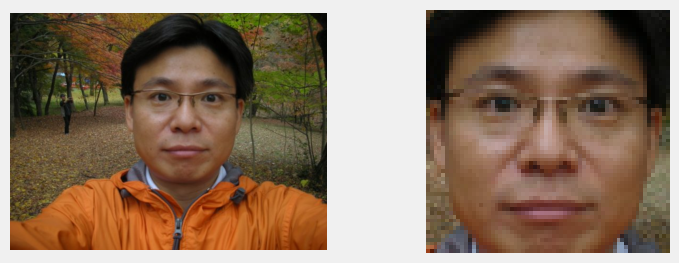

1/1 [==============================] - 0s 457ms/step
Actual[./predict/전선진_40.jpg]  >>>>  Predict[지진희] /// Accuracy : 80.00 %



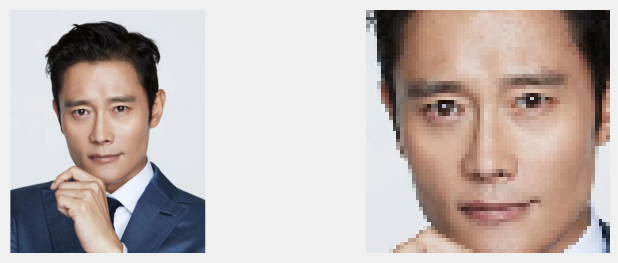

1/1 [==============================] - 0s 59ms/step
Actual[./predict/이병헌2.jpg]  >>>>  Predict[이병헌] /// Accuracy : 99.00 %



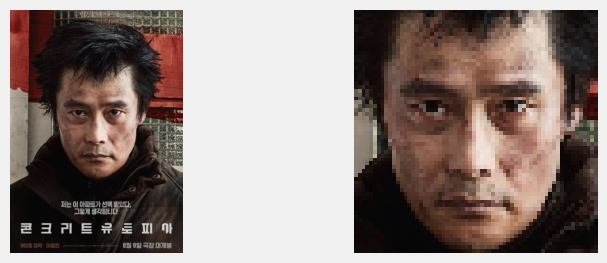

1/1 [==============================] - 0s 36ms/step
Actual[./predict/이병헌1.jpg]  >>>>  Predict[황정민] /// Accuracy : 64.00 %



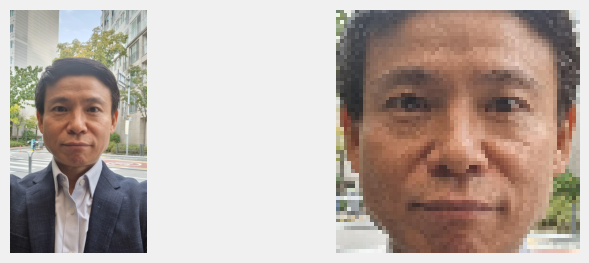

1/1 [==============================] - 0s 38ms/step
Actual[./predict/SEONJINJEON.jpg]  >>>>  Predict[최민식] /// Accuracy : 99.00 %



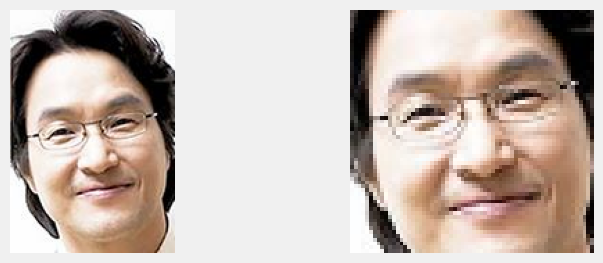

1/1 [==============================] - 0s 54ms/step
Actual[./predict/한석규1.jpg]  >>>>  Predict[송강호] /// Accuracy : 45.00 %



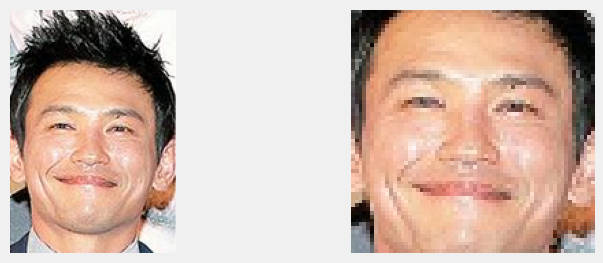

1/1 [==============================] - 0s 75ms/step
Actual[./predict/황정민.jpg]  >>>>  Predict[황정민] /// Accuracy : 99.00 %



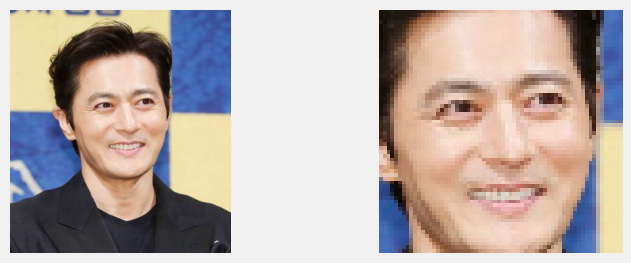

1/1 [==============================] - 0s 53ms/step
Actual[./predict/장동건.jpg]  >>>>  Predict[장동건] /// Accuracy : 99.00 %



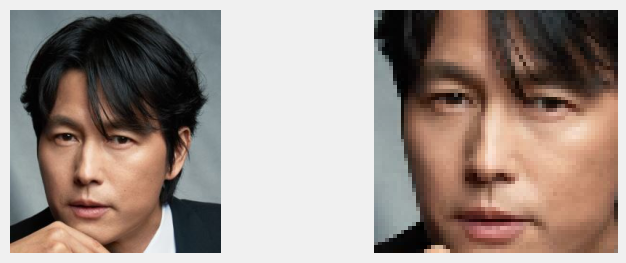

1/1 [==============================] - 0s 54ms/step
Actual[./predict/정우성.jpg]  >>>>  Predict[정우성] /// Accuracy : 86.00 %



In [6]:
getPredict(model, photo_shape, "./predict", labels)